In [1]:
import sys
import os
import tqdm

import numpy as np
import matplotlib.pyplot as plt


sys.path.insert(0, os.path.abspath("../cli"))
os.environ["PATH"] = '/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/mpi/bin:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/compilers/bin:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/cuda/bin:'+os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = '/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/nvshmem/lib:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/nccl/lib:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/mpi/lib:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/math_libs/lib64:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/compilers/lib:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/cuda/lib64:'+os.environ["LD_LIBRARY_PATH"]
os.environ["CPATH"] = '/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/nvshmem/include:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/nccl/include:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/comm_libs/mpi/include:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/math_libs/include:/home/shared/software/cuda/hpc_sdk-centos8/Linux_x86_64/23.1/cuda/include'#+os.environ["CPATH"]
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    positions_line,
    positions_half_circle,
)
from simulation.plotting import plot_velocity, plot_snapshot_and_signal
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
configuration['log-level'] = 'DEBUG'
configuration['language'] = 'openacc'
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'nvc'
configuration['mpi'] = False

### Function

In [ ]:
#run a simulation in an idealised scenario - only as long as the wave does not hit the wall.
#TODO: would be nicer to get an arrat of posy, and return an array of results
def get_ideal_signal(
    domain_size,
    f0,
    v_env,
    sd,
    ns,
    posy,
    angle,
    dt,
    spatial_dist,
    space_order,
    plot=False,
):
    max_distance = domain_size[1]
    t_end = max_distance / v_env
    s = Sonar(
        domain_size,
        f0,
        v_env,
        CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2),
        dt=dt,
        tn=t_end,
        spatial_dist=spatial_dist,
        space_order=space_order,
    )
    src_coord = np.array(
        [(domain_size[0] - sd * ns) / 2, domain_size[1] / 2]
    ) + positions_line(stop_x=ns * sd, posy=sd, n=ns)
    
    src_args = {
        "name": "src",
        "grid": s.model.grid,
        "npoint": ns,
        "f0": f0,
        "time_range": s.time_range,
        "coordinates_data": src_coord
    }
    distance = domain_size[1] / 2 * posy
    rec_x = domain_size[0] / 2 - np.cos(np.deg2rad(angle)) * distance
    rec_y = domain_size[1] / 2 + np.sin(np.deg2rad(angle)) * distance
    rec_args = {
        "name": "rec",
        "grid": s.model.grd,
        "time_range": s.time_range,
        "npoint": 1,
        "coordinates": np.array([[rec_x, rec_y]])
    }
    s.set_source("GaborSource", src_args)
    s.set_receiver("Receiver", rec_args)
    s.finalize()
    s.run_beam(angle)
    if plot:
        plot_velocity(
            s.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
        )
        plt.plot(sonar.rec.data)
    return s.rec.data[:, 0]

### Beamforming

In [ ]:
# Simplest example - water with no object, beams at a few angles
v_env = 1.5 #speed of sound - 1.5 km/s
domain_size = (60, 60) #60m by 60m domain
f0 = 50 #50Hz source
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20 #TODO: check if this is not too small?
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}

In [6]:
ns = 128 #number of sources
source_distance = 0.002 #separated by 2mm
cy = (ns - 1) / 2 * source_distance + source_distance #distance from top

#TODO: these will all be at the same angle? Why not set here? The Sonar object should be consistent in that sense
src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    a: {
    "name": "src",
    "grid": sonars[a].model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonars[a].time_range,
    "coordinates": src_coord,
    }  
    for a in angles 
}

rec_args = {
    a: {
    "name": "rec",
    "grid": sonars[a].model.grid,
    "time_range": sonars[a].time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy, 180),
    }
    for a in angles
}

for a, s in sonars.items():
    s.set_source("GaborSource", src_args[a])
    s.set_receiver("Receiver", rec_args[a])
    s.finalize()


Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for src(188887, 128) [184 MB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Operator `Kernel` generated in 1.26 s
  * lowering.Clusters: 0.72 s (57.3 %)
     * specializing.Clusters: 0.43 s (34.3 %)
        * fuse: 0.26 s (20.7 %)
  * lowering.IET: 0.28 s (22.3 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for src(188887, 128) [184 MB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Operator `Kernel` generated in 1.24 s
  * lowering.Clusters: 0.72 s (58.3 %)
     * specializing.Clusters: 0.43 s (34.8 %)
  * lowering.IET: 0.27 s (21.9 %)
Flops reduction after symbolic optimization: [92 --> 52]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for src(188887, 128) [184 MB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Operator `Kernel` generated in 1.25 s
  * lowering.Clusters: 0.

In [7]:
print(
    f"The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m"
)
print(f"The time step is {sonars[45].model.critical_dt}")
print(f"fs: {1 / sonars[45].model.critical_dt}")
print(f"Spacing: {sonars[45].model.spacing_map}")
print(f"Time range: {sonars[45].time_range.num}")

The computational grid has (6508, 6508) grid points and physical size of (65.07000000000001, 65.07000000000001) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.010000000000000002}
Time range: 188887


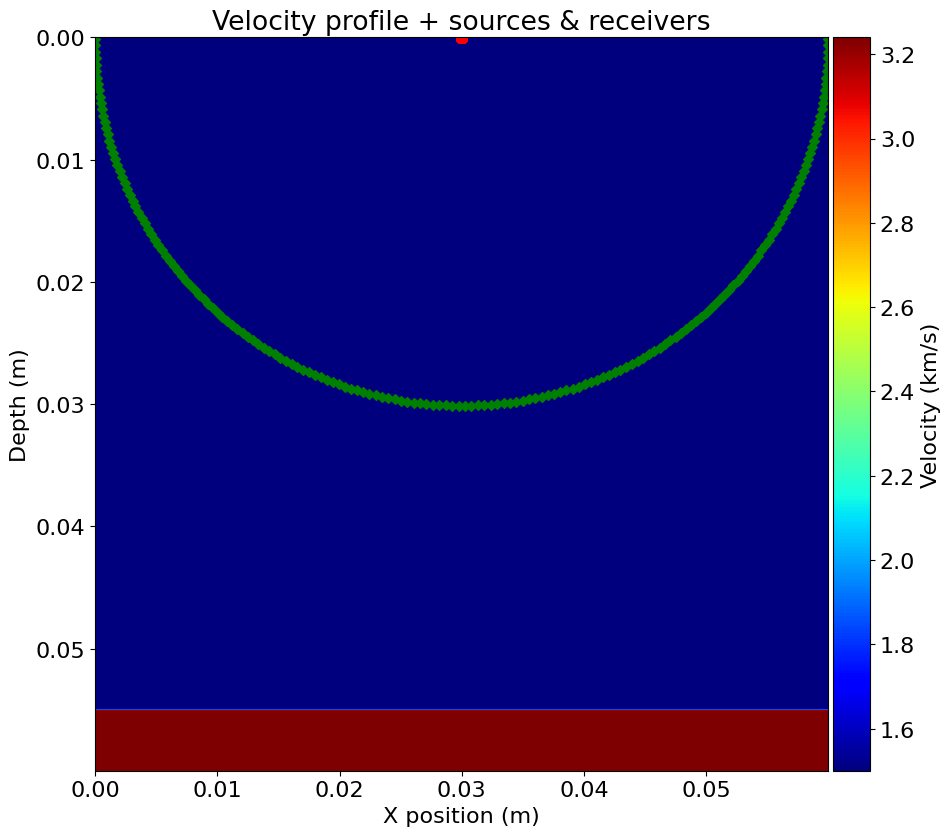

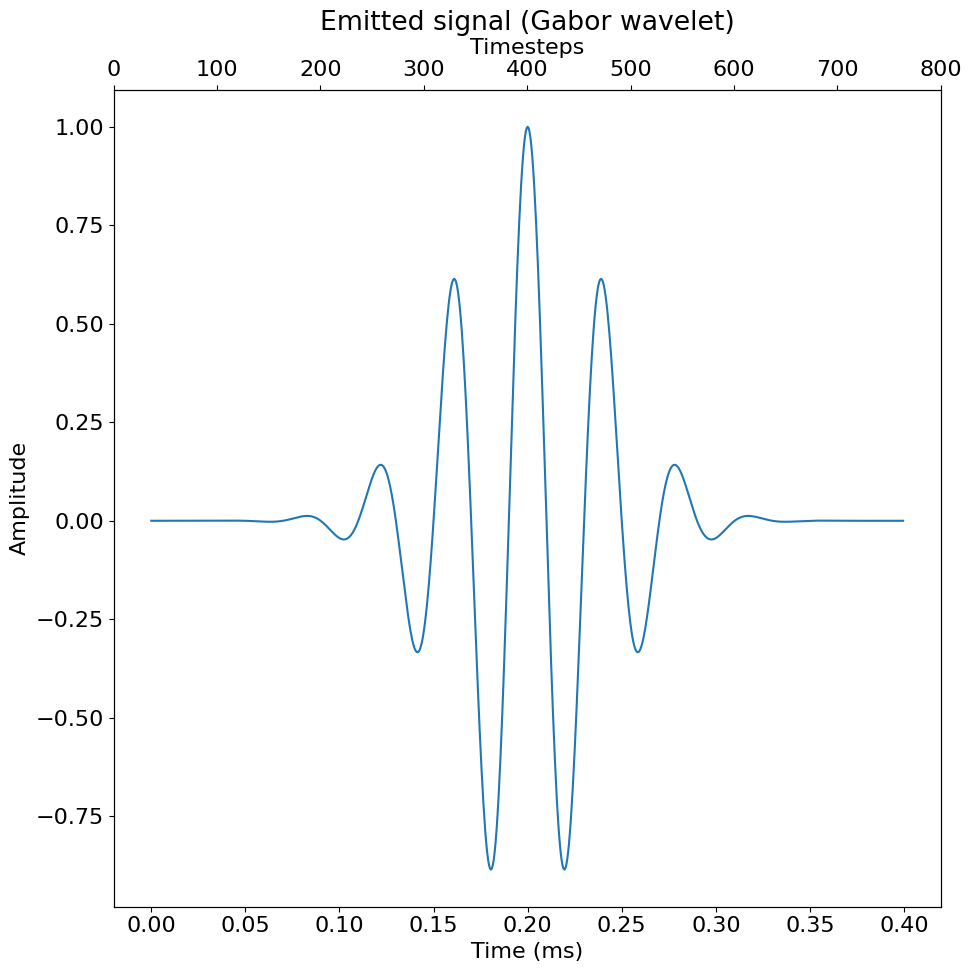

In [8]:
plot_velocity(
    sonars[45].model,
    source=sonars[45].src.coordinates.data,
    receiver=sonars[45].rec.coordinates.data,
)

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel("Timesteps")
plt.title("Emitted signal (Gabor wavelet)")
plt.tight_layout()
plt.show()

In [9]:
recordings = {}
for a, s in sonars.items():
    s.run_beam(a)
    recordings[a] = s.rec.data

Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp -lm -o /tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.87 s with `NvidiaCompiler`
Operator `Kernel` ran in 291.55 s
Global performance: [OI=1.16, 1015.30 GFlops/s, 27.44 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 286.69 s [OI=1.16, 1032.51 GFlops/s, 27.91 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.21 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.34 s [OI=0.66, 0.62 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 293.21922278404236 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.06 s
Global performance: [OI=1.16, 1010.07 GFlops/s, 27.30 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.18 s [OI=1.16, 1027.16 GFlops/s, 27.77 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.22 s [OI=3.00, 2.62 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.36 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 293.93515968322754 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.23 s
Global performance: [OI=1.16, 1009.48 GFlops/s, 27.29 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.35 s [OI=1.16, 1026.56 GFlops/s, 27.75 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.22 s [OI=3.00, 2.62 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.36 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 294.05185890197754 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.32 s
Global performance: [OI=1.16, 1009.17 GFlops/s, 27.28 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.44 s [OI=1.16, 1026.22 GFlops/s, 27.74 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.22 s [OI=3.00, 2.62 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.36 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 294.1598138809204 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.50 s
Global performance: [OI=1.16, 1008.55 GFlops/s, 27.26 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.60 s [OI=1.16, 1025.65 GFlops/s, 27.73 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.22 s [OI=3.00, 2.62 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.36 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 294.3294494152069 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.36 s
Global performance: [OI=1.16, 1009.03 GFlops/s, 27.28 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.47 s [OI=1.16, 1026.12 GFlops/s, 27.74 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.22 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.35 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 294.2087366580963 seconds


Allocating host memory for u(3, 6524, 6524) [974 MB]
Allocating host memory for rec(188887, 180) [259 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/8cad61ce0ab78bab8c7c3aeaf40bd28279fcbc76.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 293.40 s
Global performance: [OI=1.16, 1008.90 GFlops/s, 27.27 GPts/s]
Local performance:
  * section0<180> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section1<188885,6508,6508> ran in 288.54 s [OI=1.16, 1025.89 GFlops/s, 27.73 GPts/s]
  * section2<<188885,128,2,2>,<188885,128,2,2>> ran in 2.21 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<188885,180>,<188885,180,2,2>> ran in 2.35 s [OI=0.66, 0.61 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 294.24074816703796 seconds


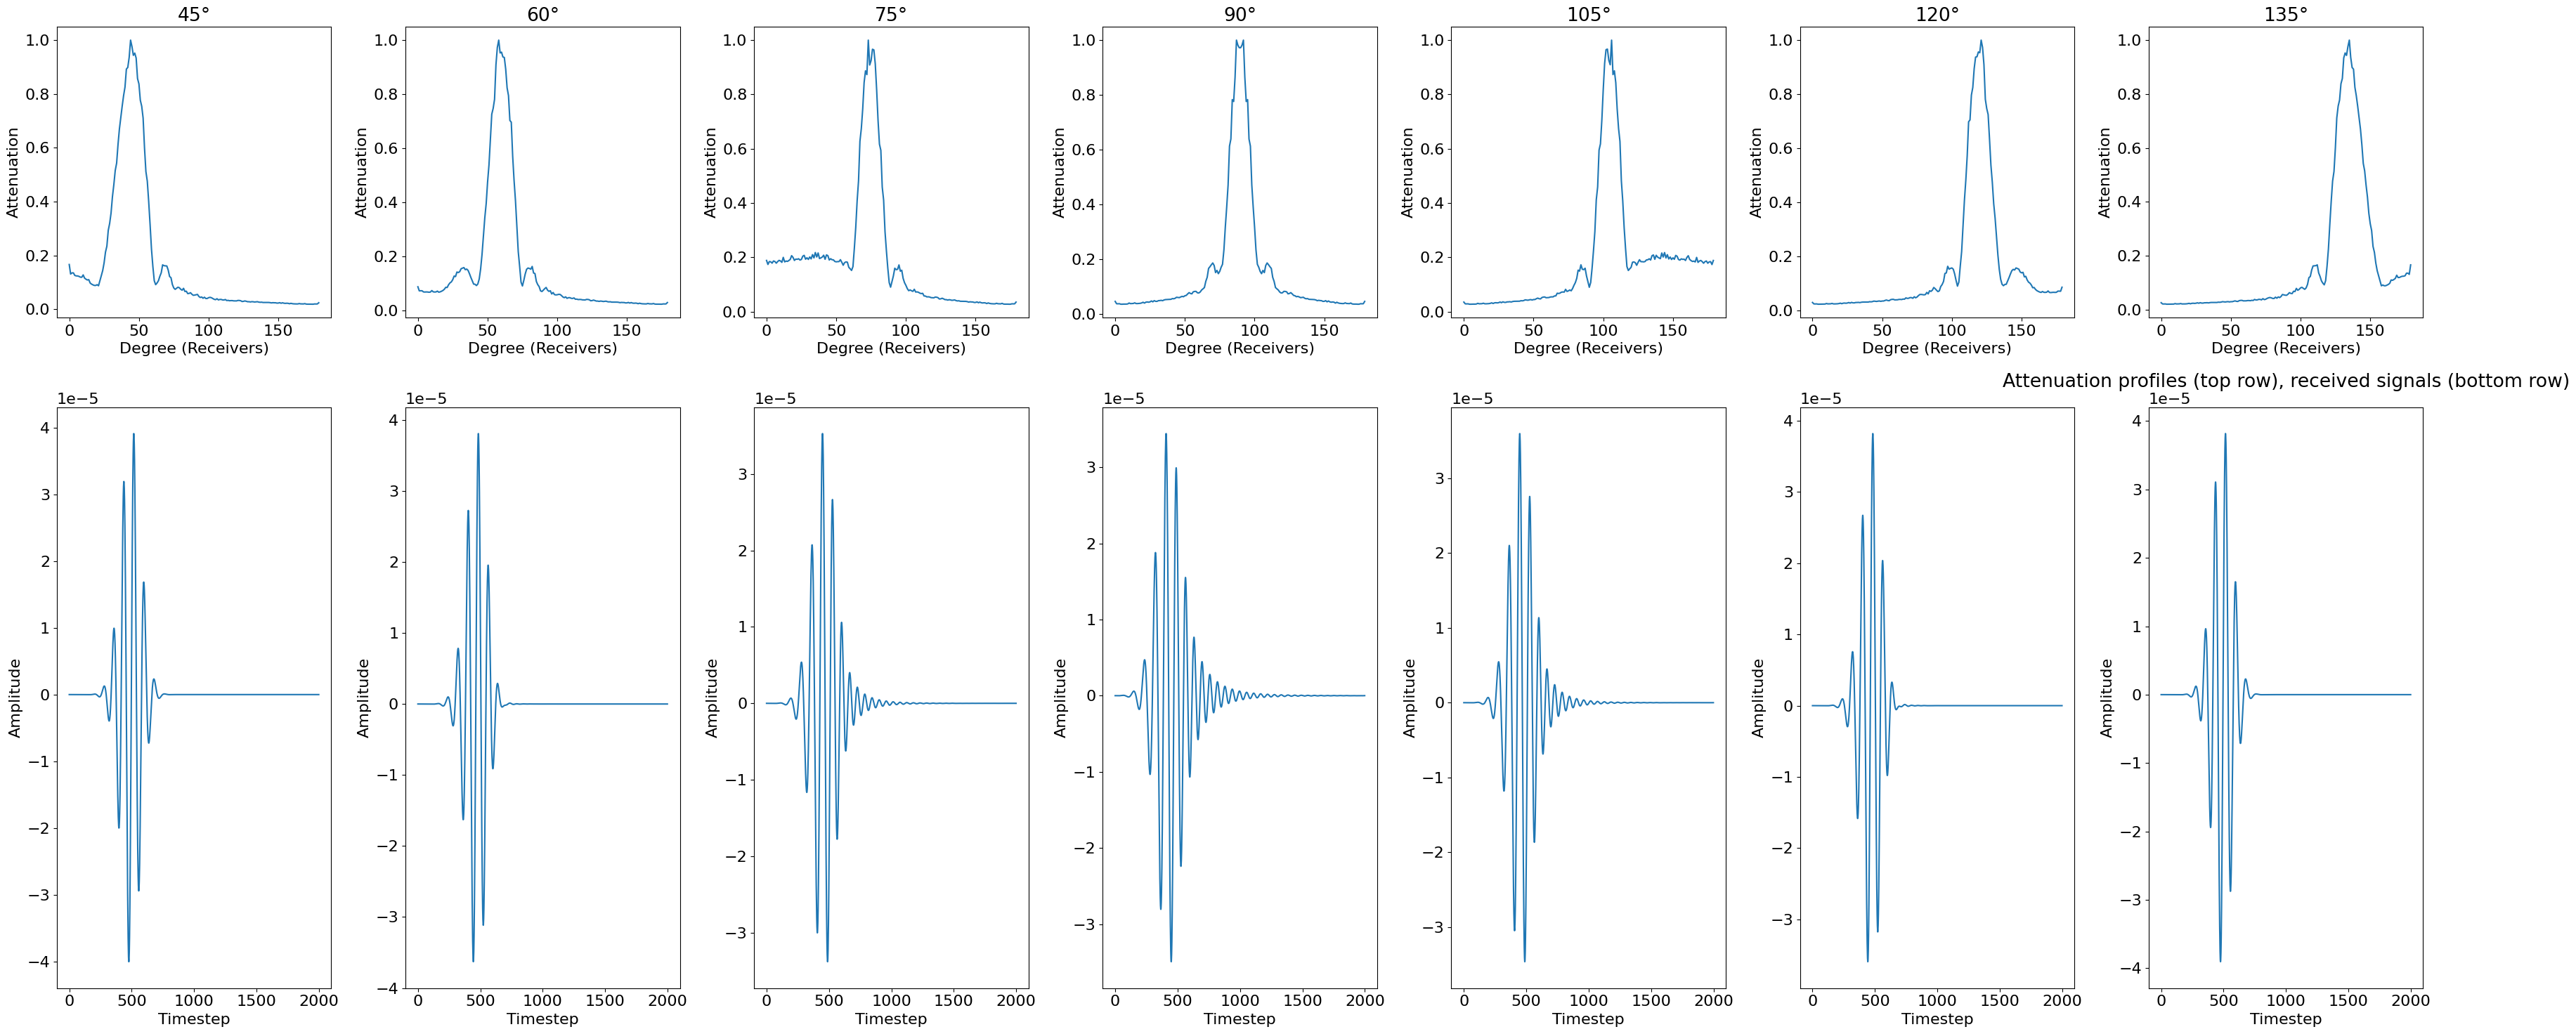

In [11]:
#Now we plot attenuation profiles and received signals
fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
plt.title("Attenuation profiles (top row), received signals (bottom row)")
for i, (a, r) in enumerate(recordings.items()):
    recording = np.flip(r)
    ax[0, i].plot(
        np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
    )
    ax[0, i].set_xlabel("Degree (Receivers)")
    ax[0, i].set_ylabel("Attenuation")
    ax[0, i].set_title(f"{a}°")
    ax[0, i].tick_params()

    ax[1, i].plot(r[40000:42000, 180 - a])
    ax[1, i].set_xlabel("Timestep")
    ax[1, i].set_ylabel("Amplitude")
fig.tight_layout()
# plt.savefig("output/beamforming.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Ideal signal

In [17]:
domain_size = (20, 20)
distances = [0.25, 0.5, 0.75]
f0 = 50
v_env = 1.5
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20
source_distance = 0.002


In [18]:
#TODO: simplify this so 1 run suffices
ideal_signals_90 = {}
snaps = {}
for d in distances:
    ideal_signals_90[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        90,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )


Operator `initdamp` generated in 0.37 s
  * lowering.IET: 0.16 s (44.1 %)
     * specializing.IET: 0.11 s (30.3 %)
  * lowering.Clusters: 0.15 s (41.3 %)
     * specializing.Clusters: 0.09 s (24.8 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800013/9e17a2851561aae8d5f5f12d84a9c245658f1cd5.cpp` in 0.02 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 250.27 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 333.69 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

IndexError: index 1 is out of bounds for axis 1 with size 1

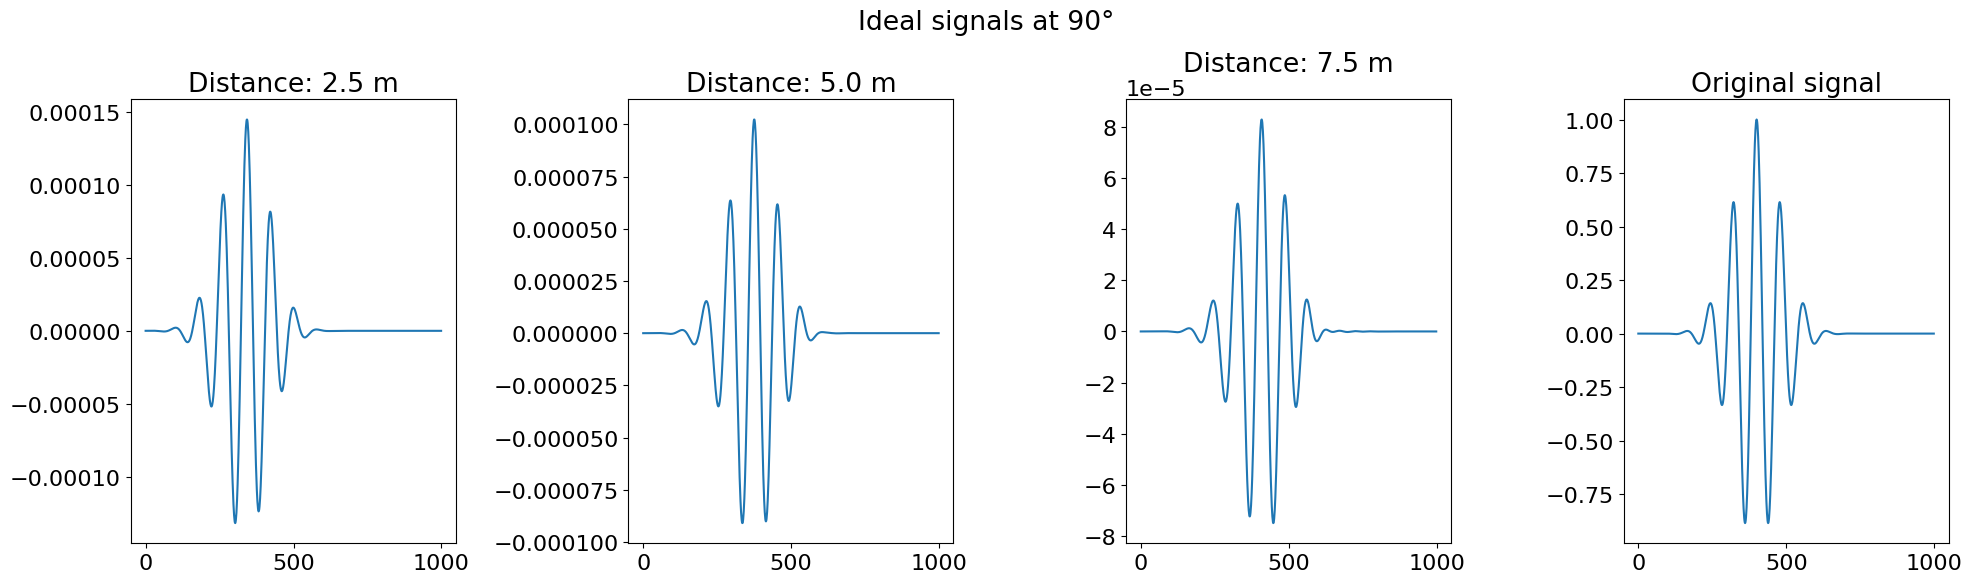

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals at 90°")
ax[0].plot(ideal_signals_90[0.25][3400:4400])
ax[0].set_title(f"Distance: {distances[0] * 20 / 2} m")
ax[1].plot(ideal_signals_90[0.5][6700:7700])
ax[1].set_title(f"Distance: {distances[1] * 20 / 2} m")
ax[2].plot(ideal_signals_90[0.75][10000:11000])
ax[2].set_title(f"Distance: {distances[2] * 20 / 2} m")
ax[3].plot(src.data[:1000, 0])
ax[3].set_title(f"Original signal")
fig.tight_layout()
plt.savefig("ideal_signals_90.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [14]:
ideal_signals_45 = {}
for d in distances:
    ideal_signals_45[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        45,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )


Operator `initdamp` generated in 0.46 s
  * lowering.Clusters: 0.21 s (46.0 %)
     * specializing.Clusters: 0.14 s (30.7 %)
  * lowering.IET: 0.18 s (39.5 %)
     * specializing.IET: 0.14 s (30.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 212.35 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.629277467727661 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.24 s (48.8 %)
     * specializing.Clusters: 0.15 s (30.5 %)
  * lowering.IET: 0.19 s (38.7 %)
     * specializing.IET: 0.14 s (28.5 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 291.98 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.652227401733398 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.23 s (47.0 %)
     * specializing.Clusters: 0.15 s (30.6 %)
  * lowering.IET: 0.19 s (38.8 %)
     * specializing.IET: 0.14 s (28.6 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 11.370994329452515 seconds


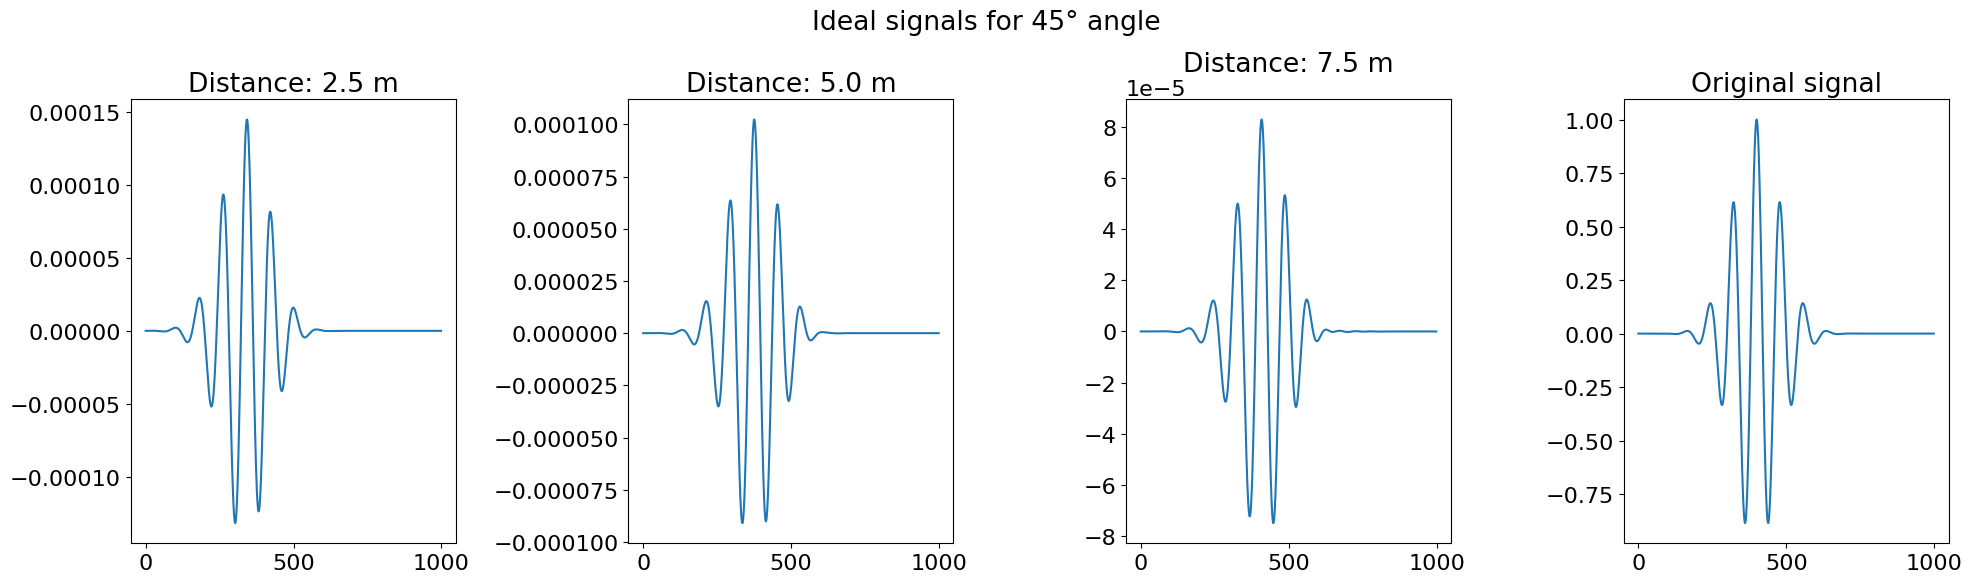

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals for 45° angle")
ax[0].plot(ideal_signals_90[0.25][3400:4400])
ax[0].set_title(f"Distance: {distances[0] * 20 / 2} m")
ax[1].plot(ideal_signals_90[0.5][6700:7700])
ax[1].set_title(f"Distance: {distances[1] * 20 / 2} m")
ax[2].plot(ideal_signals_90[0.75][10000:11000])
ax[2].set_title(f"Distance: {distances[2] * 20 / 2} m")
ax[3].plot(src.data[:1000, 0])
ax[3].set_title(f"Original signal")
fig.tight_layout()
# save the figure as pdf
plt.savefig("ideal_signals_45.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Detection with correlation

In [36]:
domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 5)
dt = spatial_dist / 20


In [37]:
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.set_receiver()
sonar.finalize()

51it [00:02, 21.74it/s]
Operator `initdamp` generated in 0.37 s
  * lowering.IET: 0.17 s (46.6 %)
     * specializing.IET: 0.11 s (30.2 %)
  * lowering.Clusters: 0.14 s (38.4 %)
     * specializing.Clusters: 0.09 s (24.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800013/9e17a2851561aae8d5f5f12d84a9c245658f1cd5.cpp` in 0.02 s from jit-cache
Operator `initdamp` ran in 0.04 s
Global performance: [OI=0.22, 1.40 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.14 GFlops/s, 0.00 GPts/s]
  * section2<254,3508> ran in 0.01 s [OI=0.69, 297.02 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section4<254,3508> ran in 0.01 s [OI=0.69, 316.18 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section6<6508,254> ran in 0.01 s [OI=0.69, 454.59 GFlops/s, 0.00 GPts/s]
  * section7<254

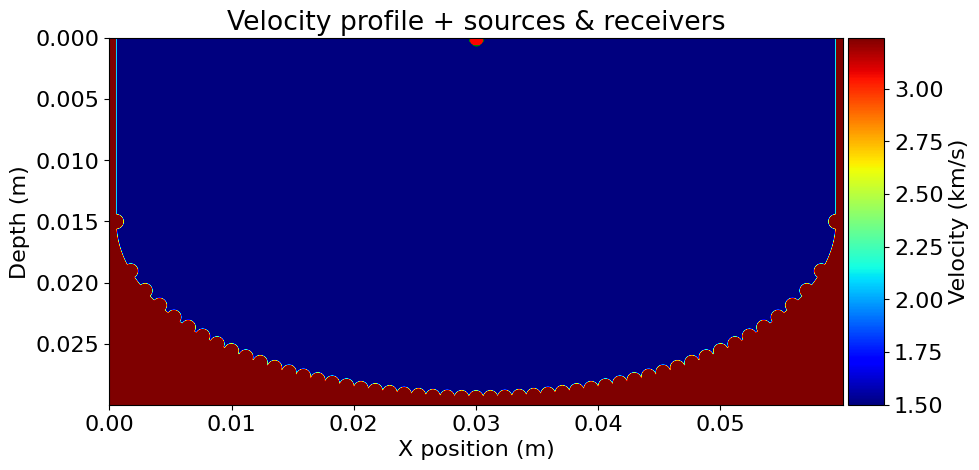

In [38]:
plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)

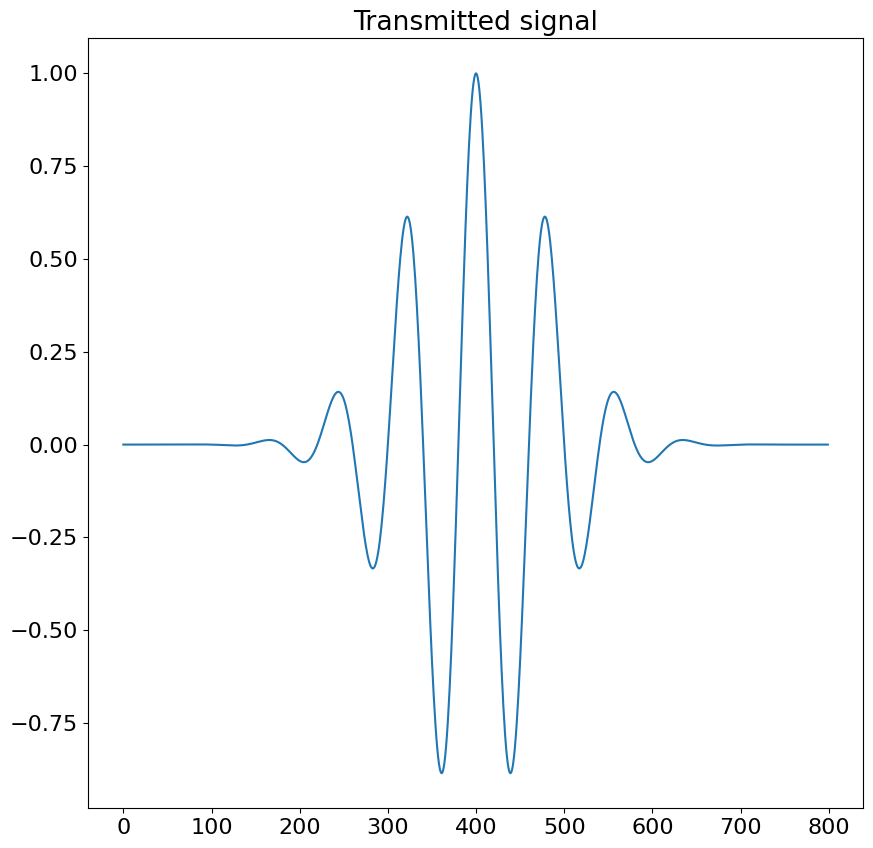

In [39]:
ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.title("Transmitted signal")
plt.show()


In [40]:
sonar.run_beam(45)
recording_45 = sonar.rec.data

Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 102.08 s
Global performance: [OI=1.28, 1129.17 GFlops/s, 27.54 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 99.14 s [OI=1.28, 1162.69 GFlops/s, 28.36 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.41 s [OI=3.00, 2.69 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.37 s [OI=0.66, 0.49 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 102.55395698547363 seconds


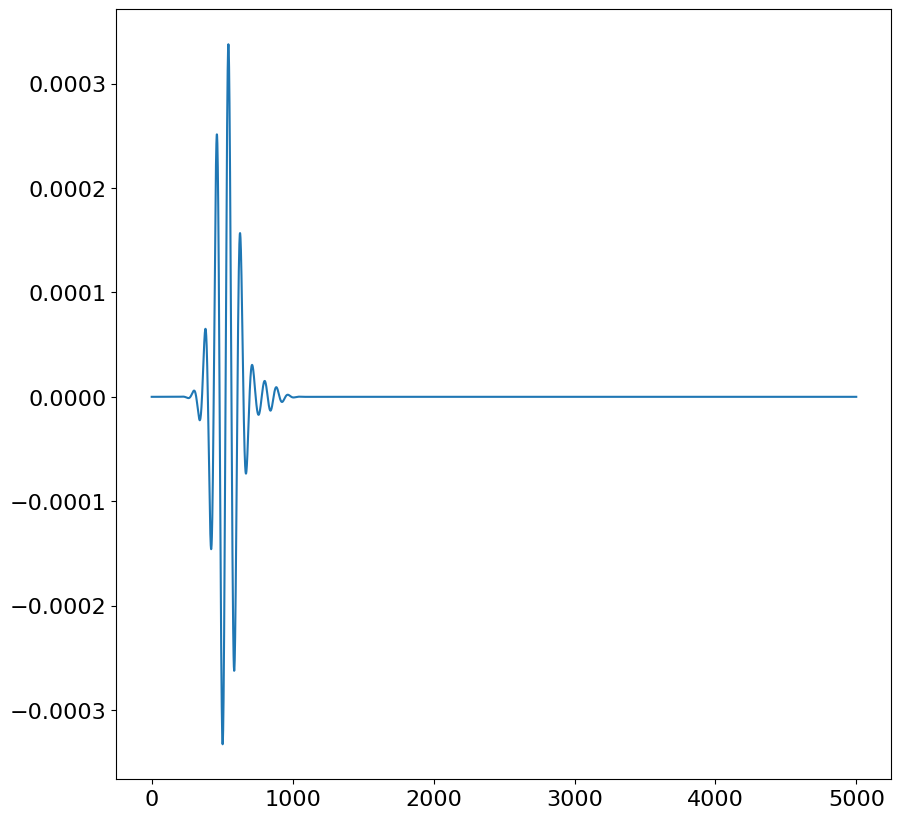

In [41]:
# The emitted signal on receivers
plt.plot(recording_45[:5000, 64])
start_time = np.argmax(recording_45[:5000, 64])


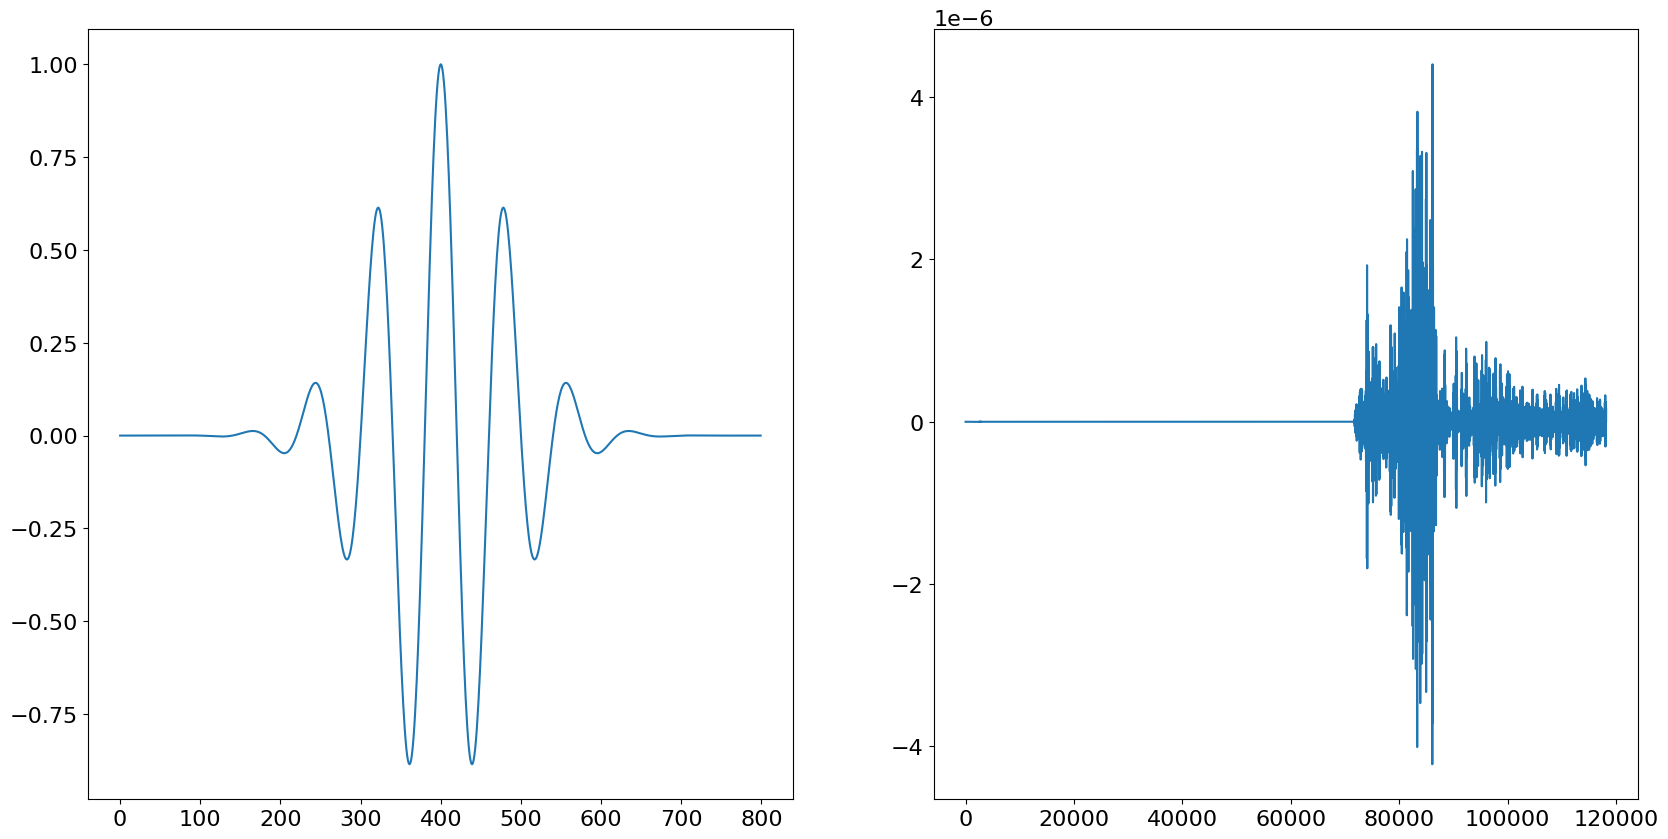

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ideal_signal)
ax[1].plot(recording_45[5000:, 64])
plt.savefig("output/correlation_ideal_recording.pdf", bbox_inches="tight", dpi=600, format="pdf")

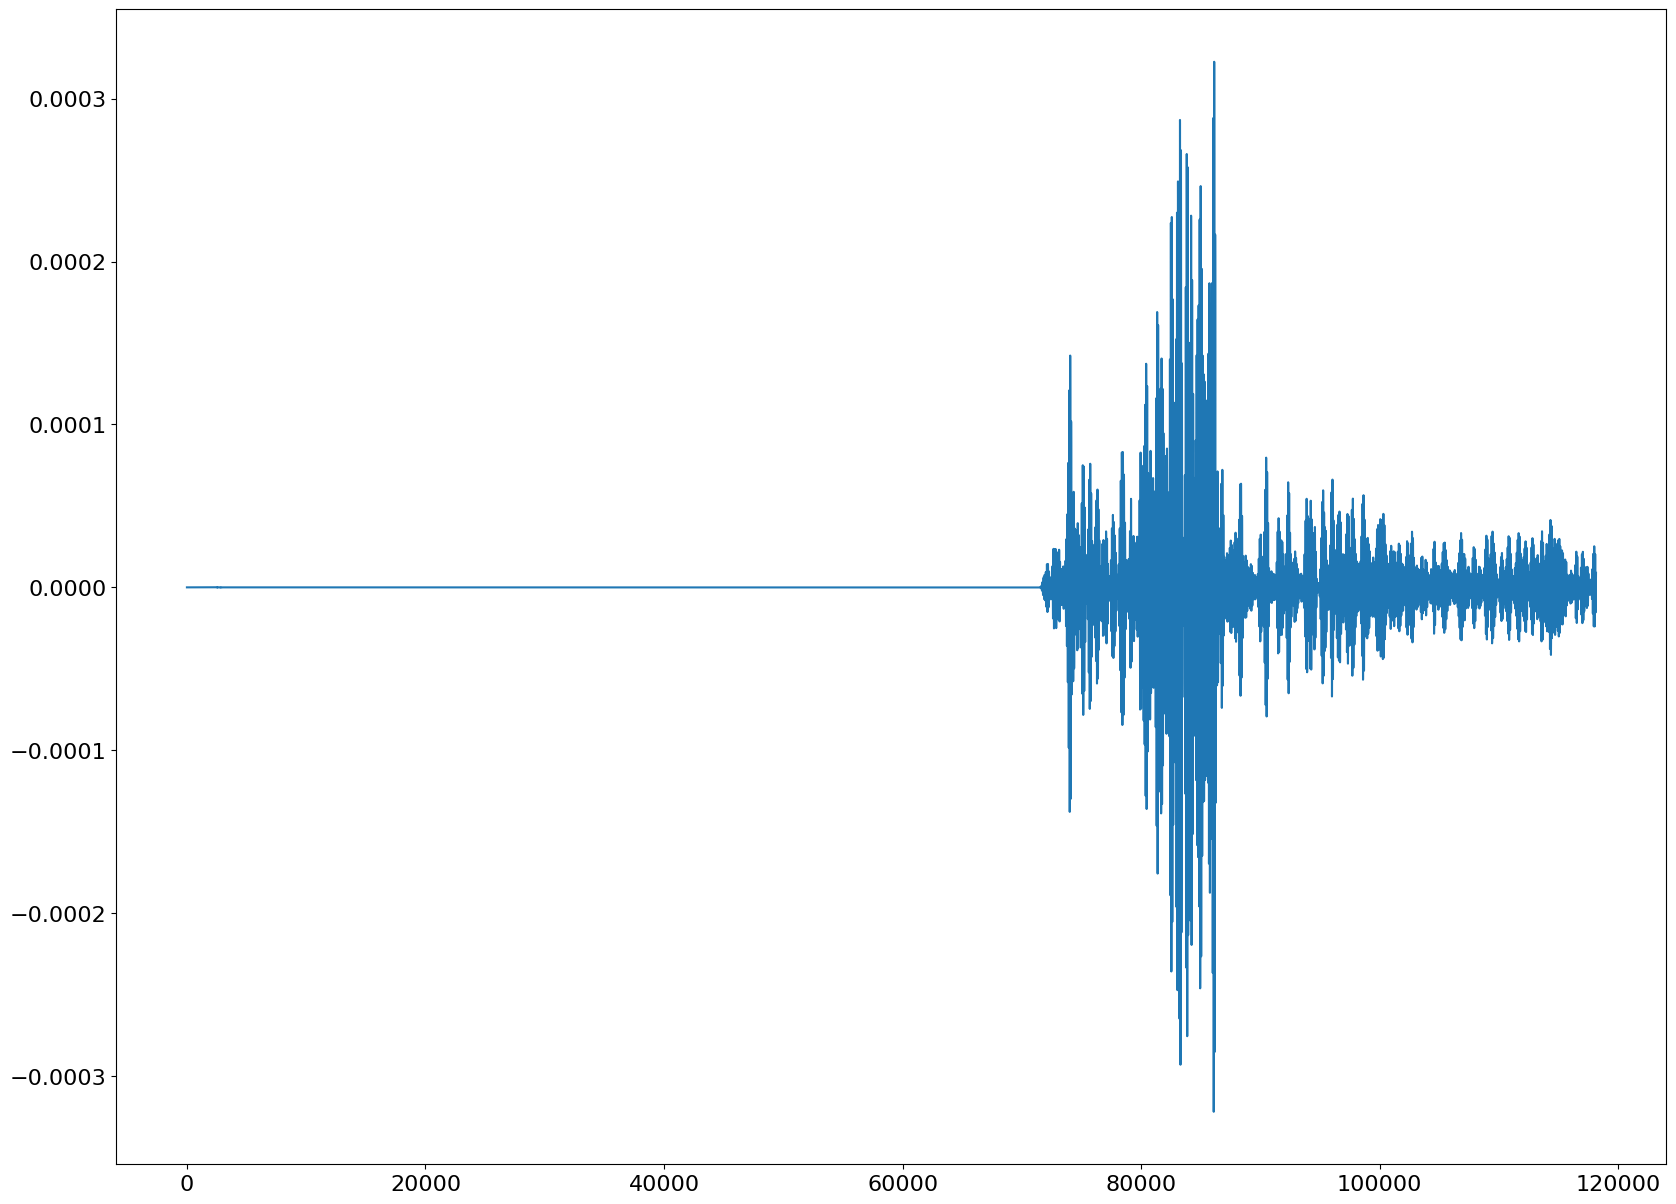

86127


In [43]:
correlate = np.correlate(recording_45[5000:, 64], ideal_signal, mode="same")
plt.figure(figsize=(20, 15))
plt.plot(correlate)
plt.show()
print(np.argmax(correlate))

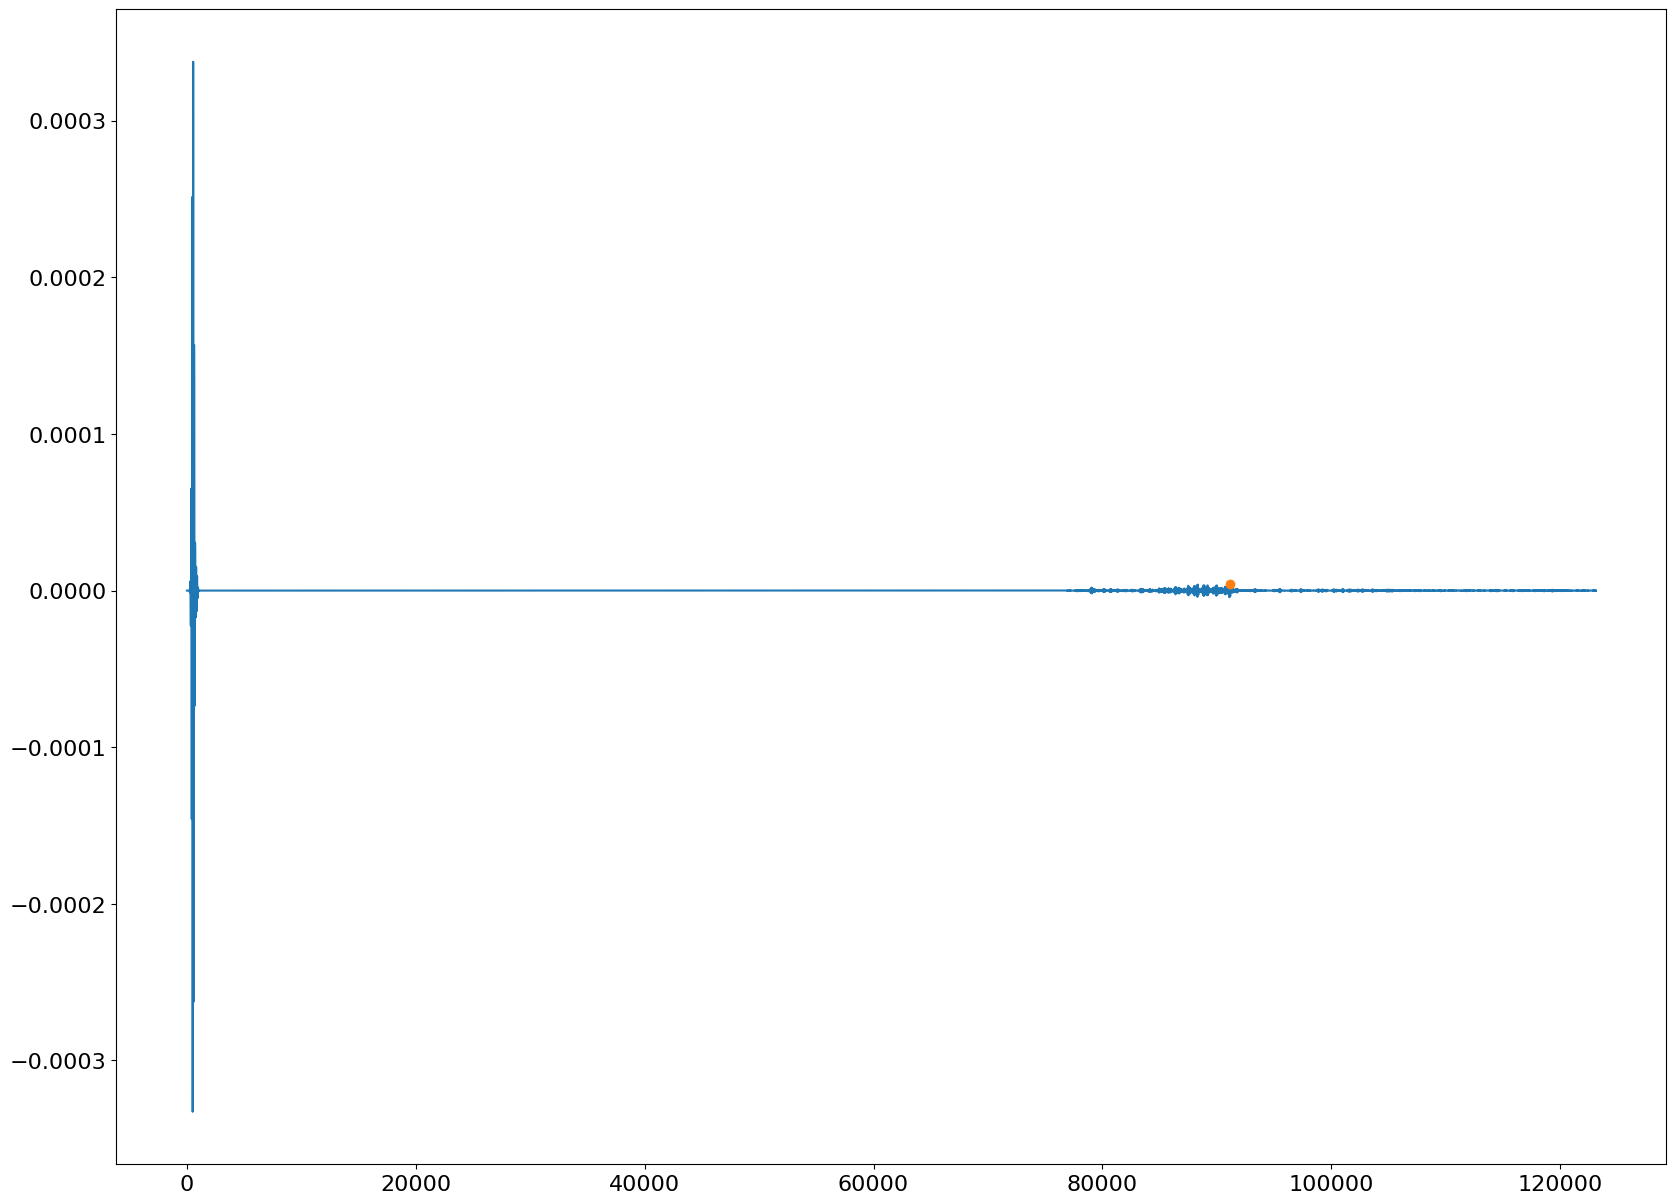

<Figure size 1000x1000 with 0 Axes>

In [44]:
peak = 5000 + correlate.argmax()
## change the figure size
plt.figure(figsize=(20, 15))
plt.plot(recording_45[:, 64])
plt.plot(peak, recording_45[peak, 64], "o")
plt.show()
plt.savefig("output/correlate.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [45]:
#TODO: this does not seem right
distance = (peak - start_time) * sonar.model.critical_dt * v_env / 2
print(f"Distance: {distance} m")


Distance: 33.968625 m


### Detect multiple angles

In [46]:
domain_size = (60, 30)
v_env = 1.5
ns = 128
source_distance = 0.002
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 5)
dt = spatial_dist / 20
angles = [30, 45, 60, 75, 90, 105, 120, 135, 150]


In [47]:
obstacle = True
v_wall = 5.64
v_obj = 3.24
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)
vp = np.full(domain_dims, v_env, dtype=np.float32)
r_obs = vp.shape[0] / 20
a, b = vp.shape[0] / 4, vp.shape[1] - r_obs
y, x = np.ogrid[-a : vp.shape[0] - a, -b : vp.shape[1] - b]
vp[x * x + y * y <= r_obs * r_obs] = v_obj
nx = domain_dims[0]
nz = domain_dims[1]
wall = round(nx * 0.02)
offs = round(wall / 2)
a = round((nx - wall) / 2)
b = round((nz - wall) / 2)
offs = round(wall / 2)
x = np.arange(0, vp.shape[0])
y = np.arange(0, vp.shape[1])
if obstacle:
    r = vp.shape[0] / 100
    ox = np.arange(offs, 2 * a + offs + 1, 2 * a / 50)
    oy = np.sqrt(1 - (ox - a - offs) ** 2 / a**2) * b + offs + b
    for oxx, oyy in tqdm.tqdm(zip(ox, oy)):
        mask = (y[np.newaxis, :] - oyy) ** 2 + (
            x[:, np.newaxis] - oxx
        ) ** 2 < r**2
        vp[mask] = v_wall
mask = (y[np.newaxis, :] - offs - b) ** 2 / b**2 + (
    x[:, np.newaxis] - offs - a
) ** 2 / a**2 > 1
vp[mask] = v_wall
vp[offs:-offs, :b] = v_env

51it [00:02, 22.35it/s]


In [49]:
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        vp,
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}
for _, v in sonars.items():
    v.set_source()
    v.set_receiver()
    v.finalize()

Operator `initdamp` generated in 0.37 s
  * lowering.IET: 0.17 s (46.1 %)
     * specializing.IET: 0.12 s (32.6 %)
  * lowering.Clusters: 0.15 s (40.7 %)
     * specializing.Clusters: 0.09 s (24.4 %)
  * lowering.IET: 0.17 s (46.1 %)
     * specializing.IET: 0.12 s (32.6 %)
  * lowering.Clusters: 0.15 s (40.7 %)
     * specializing.Clusters: 0.09 s (24.4 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800013/9e17a2851561aae8d5f5f12d84a9c245658f1cd5.cpp` in 0.02 s from jit-cache
Operator `initdamp` ran in 0.04 s
Global performance: [OI=0.22, 1.40 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2<254,3508> ran in 0.01 s [OI=0.69, 297.02 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,3508> ran in 0.01 s [OI=0.69, 326.72 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.

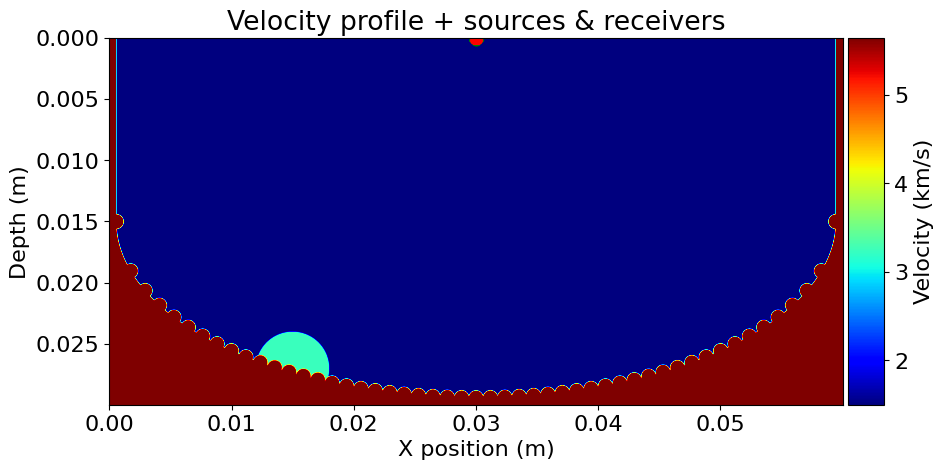

In [50]:
plot_velocity(sonars[45].model, source=sonars[45].src.coordinates.data, receiver=sonars[45].rec.coordinates.data)

In [51]:
ideal_signal = sonars[45].src.signal_packet

In [52]:
recordings = {}
for a, s in sonars.items():
    s.run_beam(a)
    recordings[a] = s.rec.data

Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 102.30 s
Global performance: [OI=1.28, 1126.74 GFlops/s, 27.49 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 99.35 s [OI=1.28, 1160.23 GFlops/s, 28.30 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.42 s [OI=3.00, 2.67 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.37 s [OI=0.66, 0.49 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 102.80552339553833 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 104.34 s
Global performance: [OI=1.28, 1104.71 GFlops/s, 26.95 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 101.35 s [OI=1.28, 1137.36 GFlops/s, 27.75 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.44 s [OI=3.00, 2.65 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.39 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.8601291179657 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 103.91 s
Global performance: [OI=1.28, 1109.28 GFlops/s, 27.06 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 100.89 s [OI=1.28, 1142.44 GFlops/s, 27.87 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.45 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.40 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.41996145248413 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 104.02 s
Global performance: [OI=1.28, 1108.11 GFlops/s, 27.03 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 101.01 s [OI=1.28, 1141.13 GFlops/s, 27.84 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.45 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.40 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.53521656990051 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 104.66 s
Global performance: [OI=1.28, 1101.33 GFlops/s, 26.87 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 101.65 s [OI=1.28, 1133.98 GFlops/s, 27.66 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.45 s [OI=3.00, 2.62 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.40 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 105.165278673172 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 103.93 s
Global performance: [OI=1.28, 1109.07 GFlops/s, 27.05 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 100.93 s [OI=1.28, 1142.03 GFlops/s, 27.86 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.44 s [OI=3.00, 2.64 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.39 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.44830799102783 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 104.05 s
Global performance: [OI=1.28, 1107.79 GFlops/s, 27.02 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 101.05 s [OI=1.28, 1140.64 GFlops/s, 27.83 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.44 s [OI=3.00, 2.63 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.40 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.57126879692078 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 104.65 s
Global performance: [OI=1.28, 1101.44 GFlops/s, 26.87 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 101.65 s [OI=1.28, 1133.92 GFlops/s, 27.66 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.44 s [OI=3.00, 2.64 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.39 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 105.14521169662476 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800013/ad622ec73d969f308075a94a2fbef40f634378a0.cpp` in 0.05 s from jit-cache
Operator `Kernel` ran in 103.93 s
Global performance: [OI=1.28, 1109.07 GFlops/s, 27.05 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.03 GFlops/s, 0.00 GPts/s]
  * section1<123137,6508,3508> ran in 100.93 s [OI=1.28, 1142.00 GFlops/s, 27.86 GPts/s]
  * section2<<123137,128,2,2>,<123137,128,2,2>> ran in 1.44 s [OI=3.00, 2.64 GFlops/s, 0.05 GPts/s]
  * section3<<123137,128>,<123137,128,2,2>> ran in 1.39 s [OI=0.66, 0.48 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.43610763549805 seconds


In [53]:
cords = np.zeros((np.size(angles), 2))
for a, v in recordings.items():
    coordinates = np.zeros((128, 2))
    for i in range(128):
        start_time = np.argmax(recordings[a][:5000, i])
        correlate = np.correlate(recordings[a][5000:, i], ideal_signal, mode="same")
        peak = 5000 + correlate.argmax()
        distance = (
            peak - start_time
        ) * sonars[a].model.critical_dt * v_env / 2
        rec_coords = sonars[a].rec.coordinates.data[i]
        coordinates[i, 0] = rec_coords[0] - distance * np.cos(np.deg2rad(a))
        coordinates[i, 1] = rec_coords[1] + distance * np.sin(np.deg2rad(a))
        cords[a // 15 - 2, :] = np.mean(coordinates, axis=0)
        

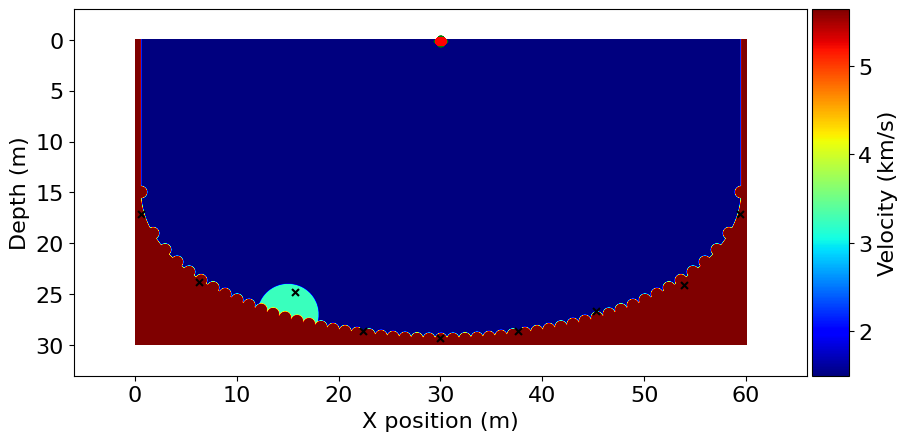

In [54]:
plot_velocity(sonars[45].model, sonars[45].src.coordinates.data, sonars[45].rec.coordinates.data, cords)

### Snapshot

In [62]:
domain_size = (60, 30)
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 15
space_order = 8
spatial_dist = round(v_env / f0 / 3, 5)
dt = spatial_dist / 20


In [63]:
obstacle = True
v_wall = 5.64
v_obj = 3.24
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)
vp = np.full(domain_dims, v_env, dtype=np.float32)
r_obs = vp.shape[0] / 20
a, b = vp.shape[0] / 4, vp.shape[1] - r_obs
y, x = np.ogrid[-a : vp.shape[0] - a, -b : vp.shape[1] - b]
vp[x * x + y * y <= r_obs * r_obs] = v_obj
nx = domain_dims[0]
nz = domain_dims[1]
wall = round(nx * 0.02)
offs = round(wall / 2)
a = round((nx - wall) / 2)
b = round((nz - wall) / 2)
offs = round(wall / 2)
x = np.arange(0, vp.shape[0])
y = np.arange(0, vp.shape[1])
if obstacle:
    r = vp.shape[0] / 100
    ox = np.arange(offs, 2 * a + offs + 1, 2 * a / 50)
    oy = np.sqrt(1 - (ox - a - offs) ** 2 / a**2) * b + offs + b
    for oxx, oyy in tqdm.tqdm(zip(ox, oy)):
        mask = (y[np.newaxis, :] - oyy) ** 2 + (
            x[:, np.newaxis] - oxx
        ) ** 2 < r**2
        vp[mask] = v_wall
mask = (y[np.newaxis, :] - offs - b) ** 2 / b**2 + (
    x[:, np.newaxis] - offs - a
) ** 2 / a**2 > 1
vp[mask] = v_wall
vp[offs:-offs, :b] = v_env

51it [00:00, 441.32it/s]


In [64]:
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    vp,
    source_distance=source_distance,
    ns=ns,
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.set_receiver()
sonar.finalize(snapshot_delay=0.1)

Operator `initdamp` generated in 0.37 s
  * lowering.IET: 0.17 s (46.6 %)
     * specializing.IET: 0.11 s (30.2 %)
  * lowering.Clusters: 0.15 s (41.1 %)
     * specializing.Clusters: 0.09 s (24.7 %)
Flops reduction after symbolic optimization: [72 --> 72]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800013/df06bf809c5ae5bc1b59c3d11edf328882624dff.cpp -lm -o /tmp/devito-jitcache-uid543800013/df06bf809c5ae5bc1b59c3d11edf328882624dff.so


Operator `initdamp` jit-compiled `/tmp/devito-jitcache-uid543800013/df06bf809c5ae5bc1b59c3d11edf328882624dff.cpp` in 0.80 s with `NvidiaCompiler`
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.22, 0.51 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<76> ran in 0.01 s [OI=0.88, 0.05 GFlops/s, 0.00 GPts/s]
  * section2<76,1052> ran in 0.01 s [OI=0.69, 62.82 GFlops/s, 0.00 GPts/s]
  * section3<76> ran in 0.01 s [OI=0.88, 0.05 GFlops/s, 0.00 GPts/s]
  * section4<76,1052> ran in 0.01 s [OI=0.69, 62.82 GFlops/s, 0.00 GPts/s]
  * section5<76> ran in 0.01 s [OI=0.88, 0.06 GFlops/s, 0.00 GPts/s]
  * section6<1952,76> ran in 0.01 s [OI=0.69, 108.80 GFlops/s, 0.00 GPts/s]
  * section7<76> ran in 0.01 s [OI=0.88, 0.06 GFlops/s, 0.00 GPts/s]
  * section8<1952,76> ran in 0.01 s [OI=0.69, 116.57 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for vp(1968, 1068) [16 MB]
Allocating host memory for s

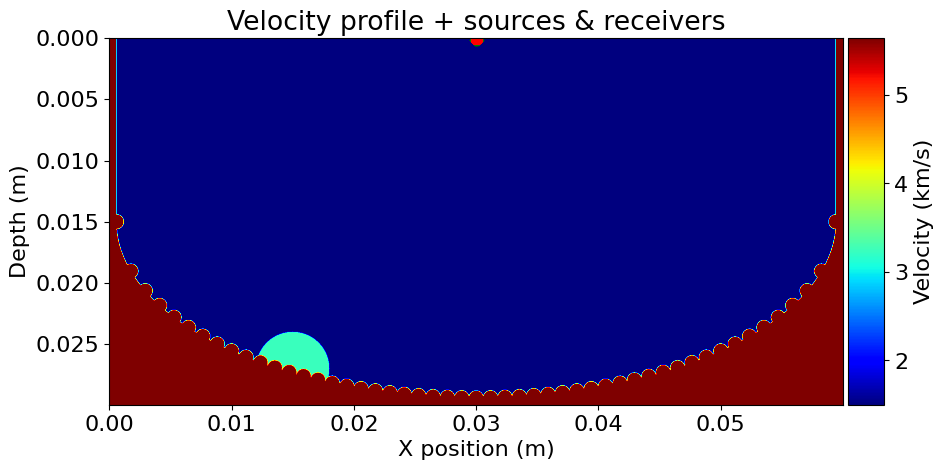

In [65]:
plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)

In [66]:
sonar.run_beam(45)
recording = sonar.rec.data

Allocating host memory for u(3, 1968, 1068) [48 MB]
Allocating host memory for rec(36946, 128) [36 MB]
Allocating host memory for usave(606, 1968, 1068) [9.5 GB]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800013/6e62463791053b0713e7246c4fe1fc4bf52eef27.cpp -lm -o /tmp/devito-jitcache-uid543800013/6e62463791053b0713e7246c4fe1fc4bf52eef27.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800013/6e62463791053b0713e7246c4fe1fc4bf52eef27.cpp` in 0.89 s with `NvidiaCompiler`
Operator `Kernel` ran in 5.62 s
Global performance: [OI=0.86, 553.70 GFlops/s, 13.50 GPts/s]
Local performance:
  * section0<128> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1<36944,1952,1052> ran in 2.91 s [OI=1.28, 1069.70 GFlops/s, 26.10 GPts/s]
  * section2<> ran in 0.02 s 
  * section3<<36944,128,2,2>,<36944,128,2,2>> ran in 0.39 s [OI=3.00, 2.92 GFlops/s, 0.05 GPts/s]
  * section4<<36944,128>,<36944,128,2,2>> ran in 0.38 s [OI=0.66, 0.53 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 9.249470710754395 seconds


In [67]:
plot_snapshot_and_signal(
    sonar.usave.data,
    recording[:, 64],
    sonar.model,
    f"output/snapshot.gif",
    sonar.src.coordinates.data,
    sonar.rec.coordinates.data,
)

MovieWriter ffmpeg unavailable; using Pillow instead.
